In [31]:
# general 
import pandas as pd 
import numpy as np 
from datetime import datetime
import pprint

# stats
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pandas.plotting import autocorrelation_plot

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
hrv_file = "04-12-21-HRV-Data-Postprocess-Kubios.csv"
cgm_file = "04-12-21-CGM-Data.csv"

## HRV Analysis
The daily HRV file from 04/12/21 is provided here and prepared for analysis. Note that unlike the CGM values which are of 24 hour, HRV is only collected as per:

- 5 minutes before breakfast
- 2 hours post dinner

In most cases, the timings for collection will vary. In this case, collection was started at 0731 hours and concluded at 2209 hours.

In [3]:
# parse HRV file  
df = pd.read_csv(hrv_file,
                     parse_dates={'date-time' : ['time', "date"]},
                     index_col='date-time'
                     )

df.drop(['seconds'], axis=1, inplace=True)
print(df)

                       rr
date-time                
2021-12-04 07:31:37   855
2021-12-04 07:31:38   855
2021-12-04 07:31:39   862
2021-12-04 07:31:40   890
2021-12-04 07:31:41   950
...                   ...
2021-12-04 22:09:13  1185
2021-12-04 22:09:15  1239
2021-12-04 22:09:16  1275
2021-12-04 22:09:17  1225
2021-12-04 22:09:18  1291

[66996 rows x 1 columns]


##### Observation
Because HRV data is the beat to beat interval, some portions are >1 sec. This means that from 7.31.37am to 22.09.18pm, there are more than 52661 seconds (14 hours converted to seconds).

Here, 66996 rows are observed. We proceed to resample it to fit 52661 seconds.

In [4]:
# resample into 1 sec intervals, pad in between values
df = df.resample('1s').median()

# some NaN values are observed. check for and replace NaN values
df['rr'].isnull().sum()

# interpolate between readings
df.interpolate(method='linear', inplace=True)

In [5]:
fig = px.line(
    df,
    x=df.index,
    y="rr"
)
fig.show()

### HRV Metrics (RMSSD, SDNN, etc)
R-R peaks are now transformed into N-N (normal to normal) peaks after ectopic/outlier beat removal and interpolation. Here, we obtain time, frequency, poincare plot, and geometrical features from our data.

A python library: hrv-analysis (https://pypi.org/project/hrv-analysis/) is used.

In [6]:
# time domain features are computed on a 5 minute window
from hrvanalysis import get_time_domain_features

# frequency domain features computed on 5 minute window
from hrvanalysis import get_frequency_domain_features

In [7]:
def obtain_features(data, timescale, feat_type):
    return data.resample(timescale).apply(feat_type)

def all_features(data, time_scale="5min"):
    return [
            obtain_features(data, time_scale, get_time_domain_features),
            obtain_features(data, time_scale, get_frequency_domain_features)
        ]

In [8]:
df_features = all_features(df)

In [9]:
time_df = pd.DataFrame(
    [_ for _ in df_features[0].rr],
    index=df_features[0].index
)

freq_df = pd.DataFrame(
    [_ for _ in df_features[1].rr],
    index=df_features[1].index
)

all_df = pd.merge(time_df, freq_df, on=time_df.index).set_index(time_df.index)
all_df.drop(labels="key_0", axis=1, inplace=True)

In [10]:
time_df.plot()

In [11]:
freq_df.plot()

In [44]:
all_df

mean_nni        sdnn       sdsd  nni_50    pnni_50  \
date-time                                                                    
2021-12-04 07:30:00   818.756829   98.216628  38.169601      21  10.396040   
2021-12-04 07:35:00   540.453712  166.350952  23.482862      13   4.347826   
2021-12-04 07:40:00   436.291667   40.013469  11.783036       3   1.003344   
2021-12-04 07:45:00   420.160000    5.387437   3.659691       0   0.000000   
2021-12-04 07:50:00   415.886667    6.589275   3.744381       0   0.000000   
...                          ...         ...        ...     ...        ...   
2021-12-04 21:45:00   908.761667  117.779926  41.979642      58  19.397993   
2021-12-04 21:50:00  1073.008333  130.873394  37.998334      51  17.056856   
2021-12-04 21:55:00  1111.516667   82.060544  38.200867      46  15.384615   
2021-12-04 22:00:00  1151.708333  133.510578  46.973883      74  24.749164   
2021-12-04 22:05:00  1167.756757  160.639989  37.157531      35  13.565891   

                     nni_20    pnni_20      rmssd  median_nni  range_nni  ...  \
date-time                                                                 ...   
2021-12-04 07:30:00      81  40.099010  38.169623      801.00      449.0  ...   
2021-12-04 07:35:00      35  11.705686  23.523468      465.75      605.0  ...   
2021-12-04 07:40:00       3   1.003344  11.783158      419.50      193.0  ...   
2021-12-04 07:45:00       0   0.000000   3.659756      420.00       32.0  ...   
2021-12-04 07:50:00       0   0.000000   3.744561      417.00       33.0  ...   
...                     ...        ...        ...         ...        ...  ...   
2021-12-04 21:45:00     169  56.521739  41.980187      881.00      493.0  ...   
2021-12-04 21:50:00     165  55.183946  37.999230     1107.00      542.0  ...   
2021-12-04 21:55:00     166  55.518395  38.202331     1131.75      414.0  ...   
2021-12-04 22:00:00     197  65.886288  46.990757     1187.00      671.0  ...   
2021-12-04 22:05:00     124  48.062016  37.159096     1229.00      626.0  ...   

                         max_hr      min_hr     std_hr           lf  \
date-time                                                             
2021-12-04 07:30:00   89.955022   53.763441   8.389257  2363.642991   
2021-12-04 07:35:00  143.884892   58.708415  25.658776   443.515575   
2021-12-04 07:40:00  159.151194  105.263158  11.078550    68.277033   
2021-12-04 07:45:00  148.514851  137.614679   1.828845     4.657099   
2021-12-04 07:50:00  150.375940  138.888889   2.300890     2.595238   
...                         ...         ...        ...          ...   
2021-12-04 21:45:00   89.686099   51.635112   8.563355  2329.888484   
2021-12-04 21:50:00   79.155673   46.153846   7.600062   943.954327   
2021-12-04 21:55:00   72.551391   48.348106   4.586540  1384.724274   
2021-12-04 22:00:00   90.634441   45.011253   8.194866  1315.682910   
2021-12-04 22:05:00   86.206897   45.385779   9.978466   691.956178   

                             hf  lf_hf_ratio       lfnu       hfnu  \
date-time                                                            
2021-12-04 07:30:00  234.212296    10.091883  90.984398   9.015602   
2021-12-04 07:35:00  139.194974     3.186290  76.112501  23.887499   
2021-12-04 07:40:00    8.320418     8.205962  89.137474  10.862526   
2021-12-04 07:45:00    0.887841     5.245418  83.988263  16.011737   
2021-12-04 07:50:00    0.610984     4.247640  80.943816  19.056184   
...                         ...          ...        ...        ...   
2021-12-04 21:45:00  239.362030     9.733743  90.683585   9.316415   
2021-12-04 21:50:00  219.977681     4.291137  81.100470  18.899530   
2021-12-04 21:55:00  170.148382     8.138334  89.057086  10.942914   
2021-12-04 22:00:00  298.917077     4.401498  81.486617  18.513383   
2021-12-04 22:05:00  183.784903     3.765033  79.013785  20.986215   

                     total_power          vlf  
date-time                                      
2021-12-04 07:30:00  898

<!-- # chunk the data into 2 minute segments
def to_chunks(values, segment_size):
    return [values[i:i+segment_size] for i in range(0,len(values),segment_size)]

two_min_chunks = to_chunks(df['rr'], segment_size=120)
five_min_chunks = to_chunks(df['rr'], segment_size=300)
twenty_min_chunks = to_chunks(df['rr'], segment_size=1200)

# using map to get features from chunks
chunked_rr_metrics = list(map(get_time_domain_features, chunked_rr))
chunked_rr_metrics[:1]

# create new datetime array
dti = pd.date_range(start="2021-12-04 07:31:37",
                    end="2021-12-04 22:09:18",
                    freq="2min")
dti

# append datetime array to dataframe
all_hrv_metrics = pd.DataFrame([_ for _ in chunked_rr_metrics])
all_hrv_metrics['date-time'] = dti
all_hrv_metrics.set_index('date-time', inplace=True) -->

In [12]:
# upsample to 1 minute buckets to match CGM data
# hrv_df = all_hrv_metrics.resample('1T').median().interpolate()
# hrv_df

## CGM Analysis
The daily CGM file from the 04/12/21 is provided here and prepared for analysis.

In [13]:
df = pd.read_csv(
    cgm_file,
    parse_dates={'date-time': ['date','time']},
    index_col ="date-time"
)

df.drop(['device', 'serial number'], axis=1, inplace=True)
df.plot()

In [14]:
# upsample into 5 min intervals from 15min CGM values, take median
df = df.resample('5T').median()

# some NaN values are observed. check for and replace NaN values
print(df['glucose'].isnull().sum())

# interpolate between readings
df.interpolate(method='linear', inplace=True)

191


In [15]:
fig = px.line(
    df,
    x=df.index,
    y='glucose'
)
fig.show()

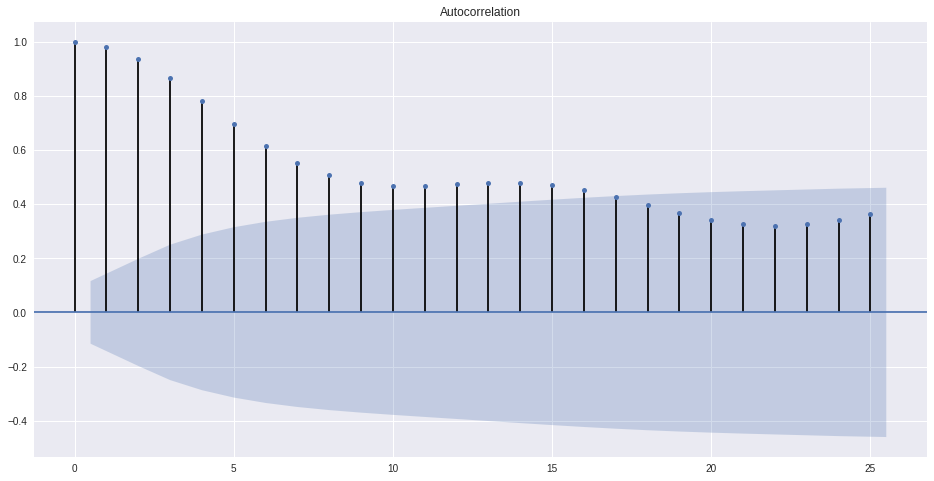

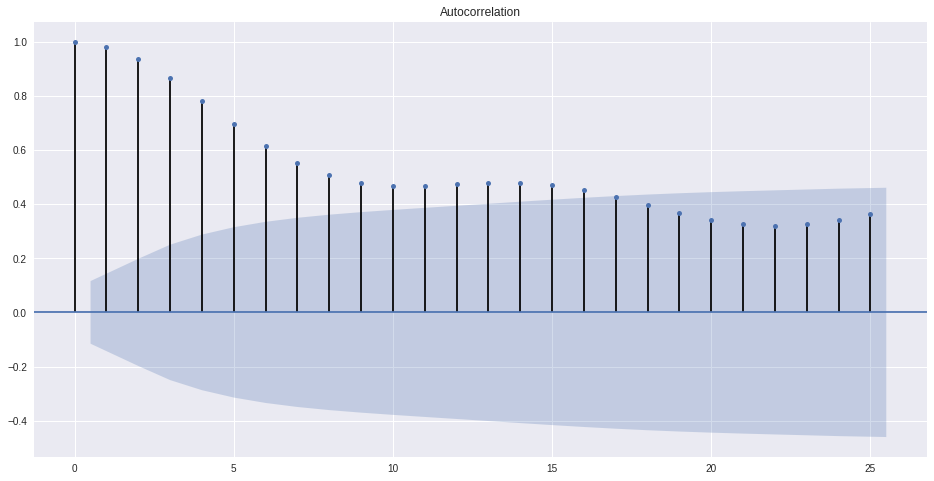

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df)

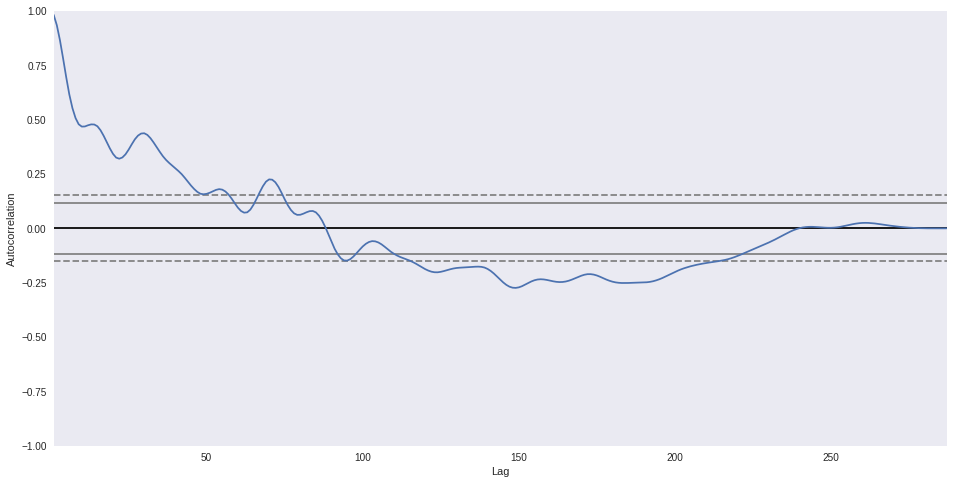

In [16]:
# examine the autocorrelation plot for CGM, on its own, we can see positive correlation for ~50 intervals.
autocorrelation_plot(df)

### Augmented Dickey-Fuller Test (ADF Test)

ADF test is used to test for stationarity of a time-series. A stationary time series does not have trends or seasonal effects. Examine if CGM univariate time series is stationary.

- Null hypothesis: TS has a unit root (non stationary)
- Alternate hypothesis: TS does **NOT** have a unit root (stationary)

In [38]:
result = adfuller(df['glucose'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.167067
p-value: 0.218415
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572


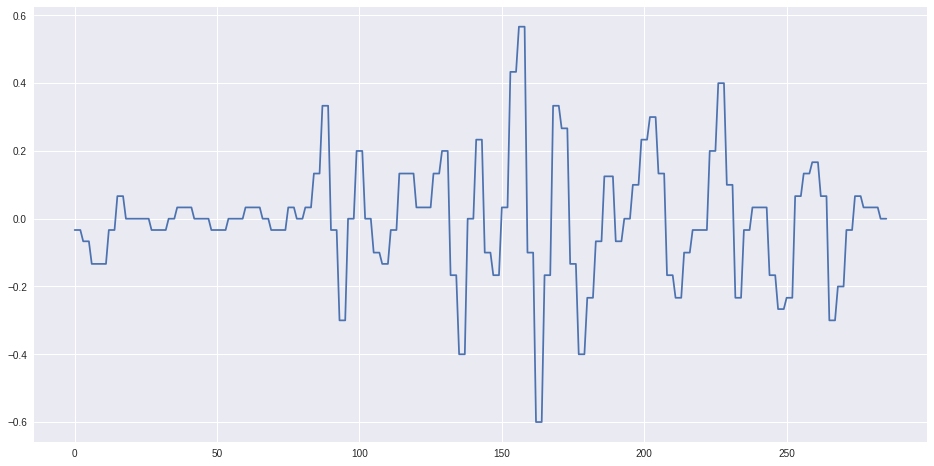

In [43]:
# take difference 
diff = list()
for i in range(1, len(df)):
    value = df['glucose'][i] - df['glucose'][i - 1]
    diff.append(value)
    
plt.plot(diff)

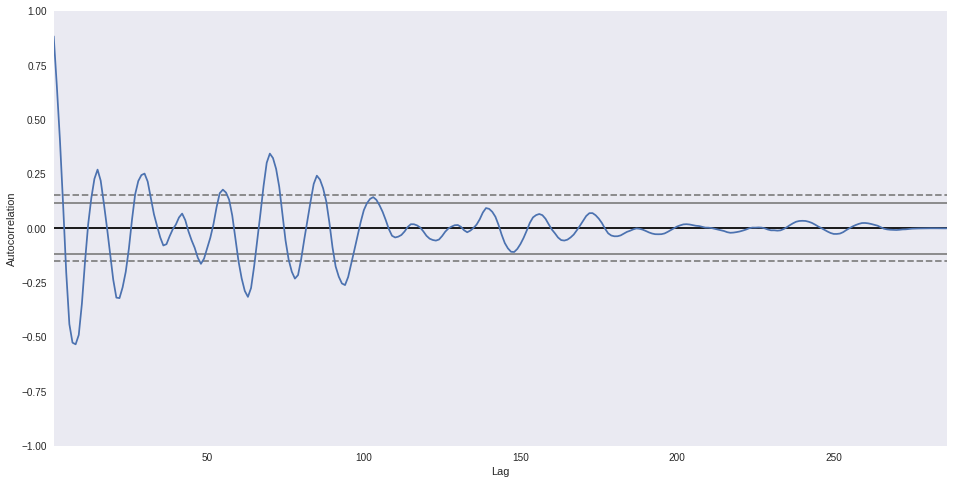

In [41]:
autocorrelation_plot(diff)

In [42]:
result = adfuller(diff, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.491948
p-value: 0.000002
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573


In [19]:
df

glucose
date-time                    
2021-12-04 00:00:00  5.400000
2021-12-04 00:05:00  5.366667
2021-12-04 00:10:00  5.333333
2021-12-04 00:15:00  5.300000
2021-12-04 00:20:00  5.233333
...                       ...
2021-12-04 23:30:00  5.066667
2021-12-04 23:35:00  5.100000
2021-12-04 23:40:00  5.100000
2021-12-04 23:45:00  5.100000
2021-12-04 23:50:00  5.100000

[287 rows x 1 columns]

In [30]:
# k = seasonal_decompose(df['glucose'], model='additive')
# k.plot()

HRV starts from 27097 seconds (7.31am). CGM data starts from 12am. Merging both CGM data frames and HRV features, merging them on the time index with an inner join.

In [26]:
final_df = pd.merge(left=df, right=all_df, left_index=True, right_index=True, how='inner')

In [27]:
final_df.plot()

Glucose and HRV have the same timestamps and can now be analyzed further, along with some data modelling.

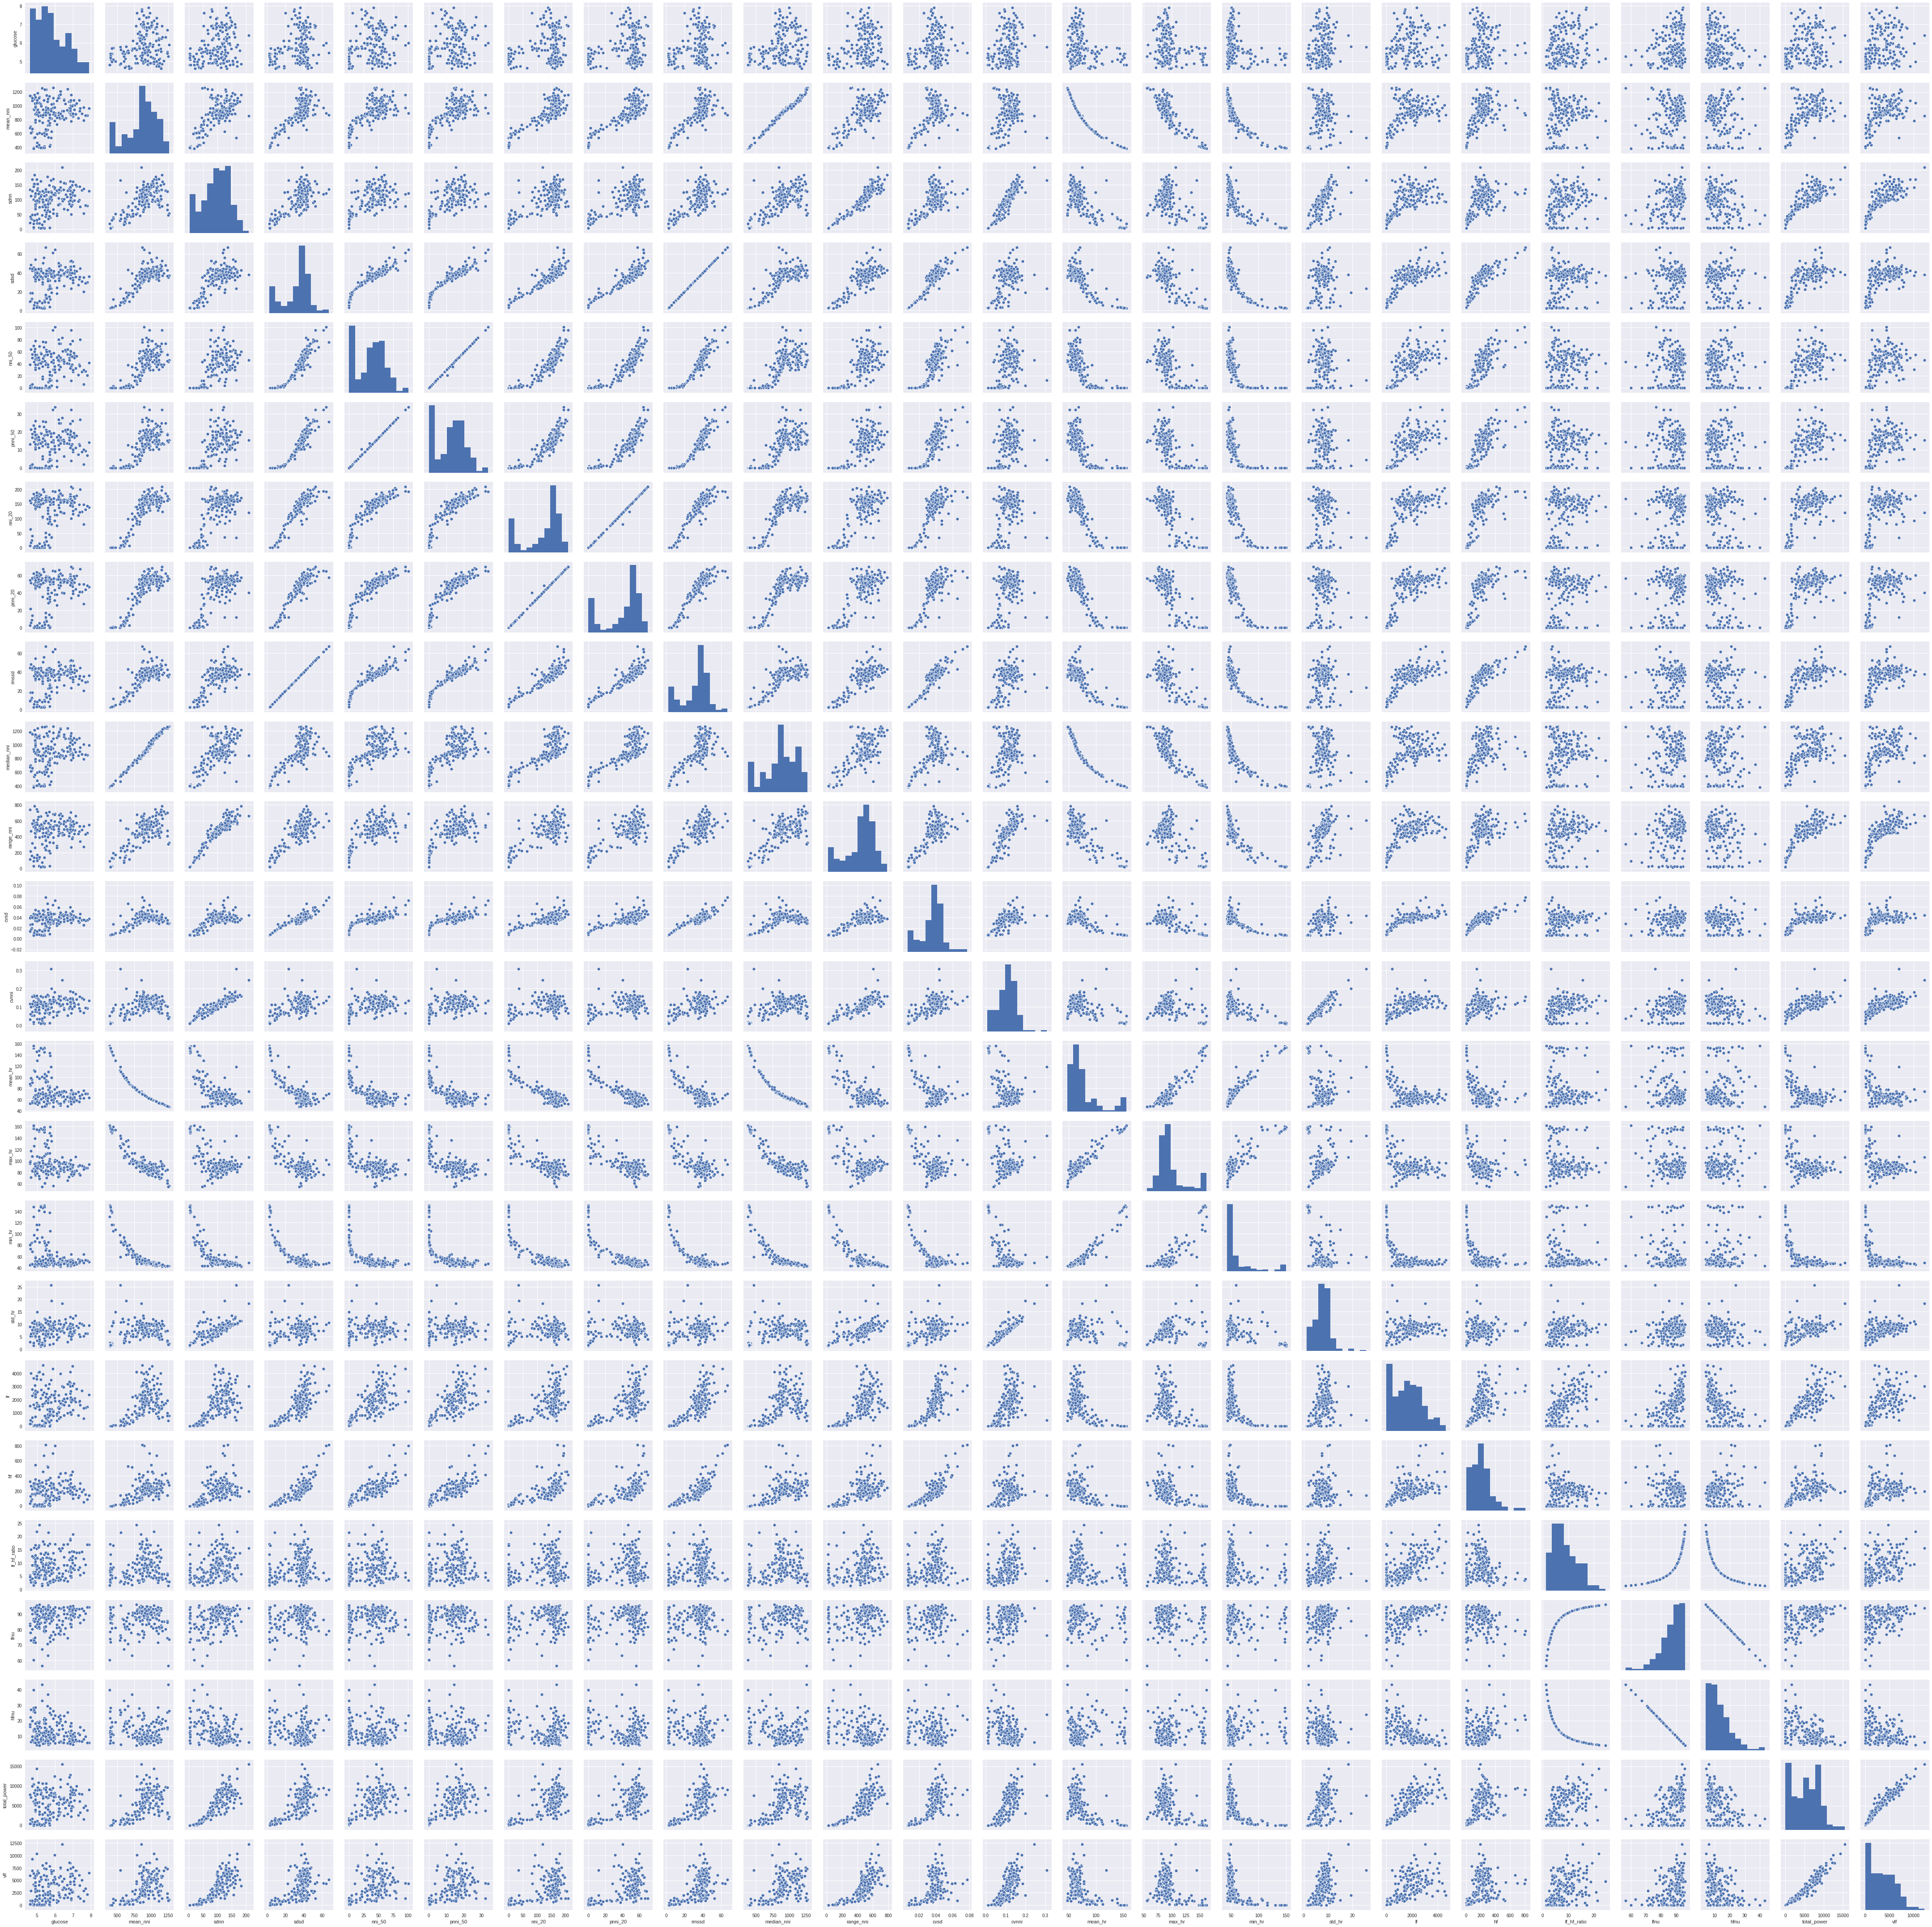

In [28]:
sns.pairplot(final_df, kind='scatter')

In [322]:
# df = pd.concat([cgm_df.reset_index(), hrv_df.reset_index()], axis=1)
# df = df.loc[:,~df.columns.duplicated()]
# df.set_index('date-time', inplace=True)
# df

In [321]:
# fig = make_subplots(
#     rows=2, cols=2,
#     subplot_titles=("Glucose", "SDNN", "RMSSD", "PNNI-50"))

# fig.add_trace(go.Histogram(x=df['glucose']),
#               row=1, col=1)

# fig.add_trace(go.Histogram(x=df['sdnn']),
#               row=1, col=2)

# fig.add_trace(go.Histogram(x=df['rmssd']),
#               row=2, col=1)

# fig.add_trace(go.Histogram(x=df['pnni_50']),
#               row=2, col=2)

# fig.update_layout(height=500, width=700,
#                   title_text="Distribution of HRV metrics and Glucose")

# fig.show()


In [324]:
# df = df.iloc[
#         df.index.get_loc('2021-12-04 10:00:00'):df.index.get_loc('2021-12-04 22:00:00')
#     ]
# df

In [20]:
final_df.describe()

glucose     mean_nni        sdnn        sdsd      nni_50  \
count  176.000000   176.000000  176.000000  176.000000  176.000000   
mean     5.808807   867.895250   96.110970   32.265485   37.221591   
std      0.824793   223.275039   46.098845   14.566017   24.959208   
min      4.600000   385.250000    2.929792    2.407242    0.000000   
25%      5.125000   765.920000   67.189320   24.955524   14.500000   
50%      5.633333   902.167083  100.405743   36.721424   41.000000   
75%      6.441667  1028.048958  130.454065   41.821351   55.000000   
max      7.900000  1265.315000  209.522832   67.127423  101.000000   

          pnni_50      nni_20     pnni_20       rmssd   median_nni  ...  \
count  176.000000  176.000000  176.000000  176.000000   176.000000  ...   
mean    12.478425  122.852273   41.199075   32.271288   874.377841  ...   
std      8.339110   63.311753   21.154433   14.567239   237.012812  ...   
min      0.000000    0.000000    0.000000    2.407312   378.500000  ...   
25%      4.849498   96.000000   32.943144   24.961967   758.375000  ...   
50%     13.712375  150.500000   50.334448   36.724342   891.750000  ...   
75%     18.394649  167.000000   55.852843   41.821529  1071.250000  ...   
max     33.779264  209.000000   69.899666   67.130305  1271.000000  ...   

           max_hr      min_hr      std_hr           lf          hf  \
count  176.000000  176.000000  176.000000   176.000000  176.000000   
mean    97.743657   62.320202    7.662570  1666.646977  204.516567   
std     24.078268   28.088847    3.367842  1151.766282  145.322237   
min     55.401662   42.283298    1.139616     1.010113    0.214342   
25%     83.030625   47.430830    5.855323   766.049288  110.408709   
50%     90.737357   50.590255    7.620253  1650.241256  199.263803   
75%    100.586968   60.060241    9.780532  2408.914851  271.991525   
max    161.725067  150.375940   25.658776  4622.002939  808.794752   

       lf_hf_ratio        lfnu        hfnu   total_power           vlf  
count   176.000000  176.000000  176.000000    176.000000    176.000000  
mean      8.802575   86.838118   13.161882   5400.835029   3529.671486  
std       4.787597    7.202483    7.202483   3534.700026   2643.883026  
min       1.305827   56.631610    3.937631      4.474052      2.562888  
25%       5.015170   83.373124    7.792071   2483.953078   1145.223098  
50%       8.103981   89.015782   10.984218   5647.025003   3179.867036  
75%      11.833575   92.207929   16.626876   8055.555289   5534.424743  
max      24.395983   96.062369   43.368390  15483.889580  12284.412892  

[8 rows x 24 columns]

#### Interpreting time series correlation
Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

Check out the bi-directional relationship between the independent variables and the dependent variables. Some other causuality tests can be tried, i.e. Granger Causality Test to investigate causality between two time series variables.

Let us try to test causality of all variables.

- Null hypothesis: HRV features do not explain variation in 'glucose'
- Alternative hypothesis: HRV features have an effect on glucose with a 95% confidence interval that a change in certain HRV features causes a response in 'glucose'

### Augmented Dickey-Fuller Test (ADF Test)

ADF test is used to test for stationarity of a time-series. A stationary time series does not have trends or seasonal effects.

- Null hypothesis: Time series has a unit root (non stationary)
- Alternate hypothesis: Time series does NOT have a unit root (stationary)

In [25]:
X = df['glucose'].values
adf_results = adfuller(X, autolag='AIC')

Some other causuality tests can be tried, i.e. Granger Causality Test to investigate causality between two time series variables.

Let us try to test causality of all variables.

- Null hypothesis: 'RMSSD' does not explain variation in 'glucose'
- Alternative hypothesis: 'RMSSD' has an effect on glucose with a 95% confidence interval that a change in 'RMSSD' causes a response in 'glucose'

In [26]:
from statsmodels.tsa.stattools import grangercausalitytests

In [27]:
df

glucose     mean_nni        sdnn       sdsd  nni_50  \
date-time                                                                   
2021-12-04 10:00:00  5.346667   603.220833   16.241064   8.998806     0.0   
2021-12-04 10:01:00  5.373333   620.404167   21.513656  10.730964     0.0   
2021-12-04 10:02:00  5.400000   619.189583   23.331055  11.305472     0.0   
2021-12-04 10:03:00  5.406667   617.975000   25.148454  11.879980     0.0   
2021-12-04 10:04:00  5.413333   619.908333   39.899877  11.533535     0.0   
...                       ...          ...         ...        ...     ...   
2021-12-04 22:02:00  6.246667  1118.829167  188.084711  46.562012    29.0   
2021-12-04 22:03:00  6.260000  1092.537500  194.812862  44.162433    28.0   
2021-12-04 22:04:00  6.273333  1161.854167  134.469976  41.109496    22.0   
2021-12-04 22:05:00  6.286667  1231.170833   74.127091  38.056558    16.0   
2021-12-04 22:06:00  6.300000  1221.815809   70.037370  37.385780    16.0   

                       pnni_50  nni_20    pnni_20      rmssd  median_nni  \
date-time                                                                  
2021-12-04 10:00:00   0.000000     4.5   3.781513   9.008226     603.000   
2021-12-04 10:01:00   0.000000     9.0   7.563025  10.731149     620.000   
2021-12-04 10:02:00   0.000000     9.0   7.563025  11.317324     621.125   
2021-12-04 10:03:00   0.000000     9.0   7.563025  11.903499     622.250   
2021-12-04 10:04:00   0.000000     9.0   7.563025  11.594241     628.625   
...                        ...     ...        ...        ...         ...   
2021-12-04 22:02:00  24.369748    75.5  63.445378  46.674689    1193.000   
2021-12-04 22:03:00  23.529412    72.0  60.504202  44.381416    1177.500   
2021-12-04 22:04:00  18.487395    62.0  52.100840  41.310218    1212.000   
2021-12-04 22:05:00  13.445378    52.0  43.697479  38.239021    1246.500   
2021-12-04 22:06:00  14.643481    52.5  48.086363  37.478486    1234.250   

                     range_nni      cvsd     cvnni    mean_hr      max_hr  \
date-time                                                                   
2021-12-04 10:00:00      94.25  0.014864  0.026697  99.621724  107.677865   
2021-12-04 10:01:00     126.50  0.017297  0.034677  96.825331  106.856634   
2021-12-04 10:02:00     129.75  0.018280  0.037686  97.039231  107.191758   
2021-12-04 10:03:00     133.00  0.019262  0.040695  97.253130  107.526882   
2021-12-04 10:04:00     182.25  0.018705  0.064291  97.284207  115.555408   
...                        ...       ...       ...        ...         ...   
2021-12-04 22:02:00     639.00  0.041692  0.168343  55.679406   88.420669   
2021-12-04 22:03:00     607.00  0.040622  0.178312  57.151129   86.206897   
2021-12-04 22:04:00     565.00  0.035841  0.119260  53.056762   81.174514   
2021-12-04 22:05:00     523.00  0.031059  0.060209  48.962394   76.142132   
2021-12-04 22:06:00     404.00  0.030671  0.057300  49.300541   67.000671   

                        min_hr     std_hr  
date-time                                  
2021-12-04 10:00:00  92.385139   2.611425  
2021-12-04 10:01:00  87.209302   3.312531  
2021-12-04 10:02:00  87.019991   3.656135  
2021-12-04 10:03:00  86.830680   3.999739  
2021-12-04 10:04:00  85.256344   6.750296  
...                        ...        ...  
2021-12-04 22:02:00  45.529418  12.134093  
2021-12-04 22:03:00  46.047583  12.649581  
2021-12-04 22:04:00  45.907086   8.254712  
2021-12-04 22:05:00  45.766590   3.859843  
2021-12-04 22:06:00  45.576185   3.342192  

[727 rows x 17 columns]

In [28]:
def normalize(data, percentage=True):
    # divide every data point by the first sample
    norm = data.div(data.iloc[0])
    return norm.mul(100) if percentage else norm

norm = normalize(df)
norm.drop([
    'mean_nni',
    'sdsd',
    'nni_50',
    'pnni_50',
    'nni_20',
    'pnni_20',
    'median_nni',
    'range_nni',
    'cvsd',
    'cvnni',
    'mean_hr',
    'max_hr',
    'min_hr',
    'std_hr'
    ], axis=1, inplace=True)
norm.head()

glucose        sdnn       rmssd
date-time                                              
2021-12-04 10:00:00  100.000000  100.000000  100.000000
2021-12-04 10:01:00  100.498753  132.464567  119.126113
2021-12-04 10:02:00  100.997506  143.654715  125.633217
2021-12-04 10:03:00  101.122195  154.844864  132.140322
2021-12-04 10:04:00  101.246883  245.672797  128.707262

In [29]:
fig = px.line(
    norm,
    x=norm.index,
    y=[norm['glucose'], norm["sdnn"], norm["rmssd"]]
)
fig.show()